# Методы регуляризации

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import clear_output
import numpy as np

## Генерация данных

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, n_features=2, centers=[[0, 0.7], [0, -0.7]], random_state=12)

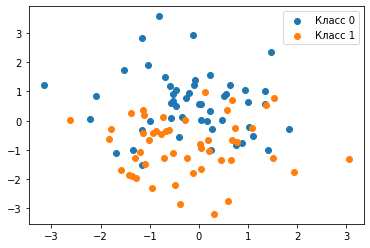

In [3]:
plt.scatter(X[y==0, 0], X[y==0, 1], label='Класс 0')
plt.scatter(X[y==1, 0], X[y==1, 1], label='Класс 1')
plt.legend()
plt.show()

## Разделение на обучающую и тестовую выборки

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=13)

## Обучение нейронной сети

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Зададим архитектуру нашей сети

In [7]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        
        self.net = nn.Sequential(nn.Linear(2, 100), 
                                 nn.Tanh(), 
                                 nn.Linear(100, 100), 
                                 nn.Tanh(), 
                                 nn.Linear(100, 1), 
                                 nn.Sigmoid())
        
    def forward(self, x):
        return self.net(x)

Обучим нашу сеть

In [8]:
class Fitter(object):
    
    def __init__(self, model, n_epochs=100, batch_size=64, lr=0.01, weight_decay=0.):        
        
        self.model = model
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.lr = lr
        self.weight_decay = weight_decay
        
    
    def fit(self, X_train, y_train, X_test, y_test):
        
        # Конвертируем данные в тензоры
        X_train = torch.as_tensor(X_train, dtype=torch.float32, device=device)
        y_train = torch.as_tensor(y_train.reshape(-1, 1), dtype=torch.float32, device=device)
        
        X_test = torch.as_tensor(X_test, dtype=torch.float32, device=device)
        y_test = torch.as_tensor(y_test.reshape(-1, 1), dtype=torch.float32, device=device)
        
        # Создаем датасет
        train_data = TensorDataset(X_train, y_train)
        
        # Определим функцию потерь
        loss_func = nn.BCELoss()
        
        # Зададим оптимизатор
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        # Контейнеры для хранения кривых обучения
        train_loss_history = []
        test_loss_history = []
        
        # Цикл обучения
        for epoch_i in range(self.n_epochs):
            for x_batch, y_batch in DataLoader(train_data, batch_size=self.batch_size, shuffle=True):
                
                self.model.train(True)
                y_pred_batch = self.model(x_batch)
                loss = loss_func(y_pred_batch, y_batch)
                opt.zero_grad() # обнуляем градиенты
                loss.backward() # обратное распространение
                opt.step()      # обновление весов сети
                
                # считаем функцию потерь на обучении
                self.model.train(False)
                y_pred_train = self.model(X_train)
                train_loss = loss_func(y_pred_train, y_train)
                train_loss_history.append(train_loss.item())
                
                # считаем функцию потерь на тесте
                y_pred_test = self.model(X_test)
                test_loss = loss_func(y_pred_test, y_test)
                test_loss_history.append(test_loss.item())
            
            # строим графики кривых обучения
            if epoch_i % 10 == 0:
                clear_output(wait=True)
                plt.figure(figsize=(9, 6))
                plt.plot(train_loss_history, linewidth=3, label="Обучение")
                plt.plot(test_loss_history, linewidth=3, label="Тест")
                plt.legend(fontsize=14)
                plt.xlabel("Итерации", size=14)
                plt.ylabel("Функция потерь", size=14)
                #plt.ylim(0., 1.)
                plt.grid(b=1)
                plt.show()
            
        return self.model
    
    def predict(self, X):
        self.model.train(False)
        X = torch.as_tensor(X, dtype=torch.float32, device=device)
        y_pred = self.model(X)
        y_pred = y_pred.cpu().detach().numpy()
        return y_pred

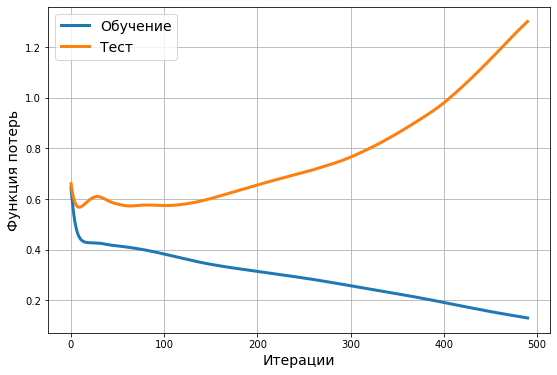

In [9]:
model = MyNet()

fitter = Fitter(model, n_epochs=500, batch_size=50, lr=0.001, weight_decay=0.)
_ = fitter.fit(X_train, y_train, X_test, y_test)

In [10]:
def plot_decision_boundary(clf):

    plt.figure(figsize=(8, 8))
    # Рисуем объекты класса 0
    plt.scatter(X_train[y_train == 0, 0],     # берем все объекты с y == 0 и их первую координату X1
                X_train[y_train == 0, 1],     # берем все объекты с y == 0 и их вторую координату X2
                color='r',                    # задачем цвет
                label='Класс 0')              # метка для легенды


    # Рисуем объекты класса 1
    plt.scatter(X_train[y_train == 1, 0],     # берем все объекты с y == 1 и их первую координату X1
                X_train[y_train == 1, 1],     # берем все объекты с y == 0 и их вторую координату X2
                color='b',                    # задачем цвет
                label='Класс 1')              # метка для легенды


    ### ЭТО ЧЕРНАЯ МАГИЯ :)

    # рисуем разделяющую поверхность
    h=0.1
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = 1 * (Z >= 0.5)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.6, levels=1)

    ### ЧЕРНАЯ МАГИЯ ЗАКОНЧИЛАСЬ


    plt.xlabel('X1', size=14)
    plt.ylabel('X2', size=14)

    plt.legend(loc='best') # создаем легенду
    plt.grid(b=1) # рисуем сетку

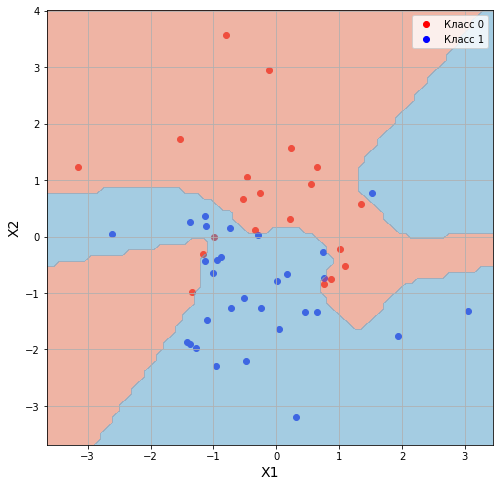

In [11]:
# обучающая выборка
plot_decision_boundary(fitter)

## L2 регуляризация

Обучим ту же сеть, но зададим L2 регуляризацию `weight_decay`

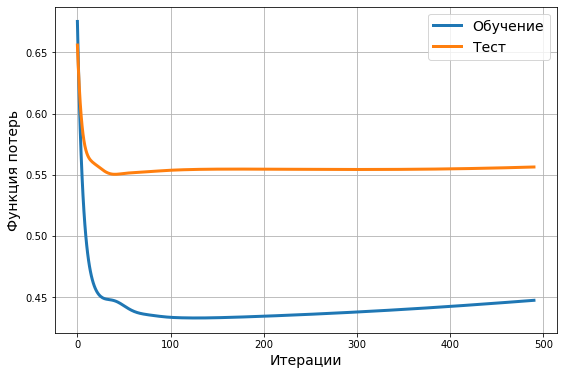

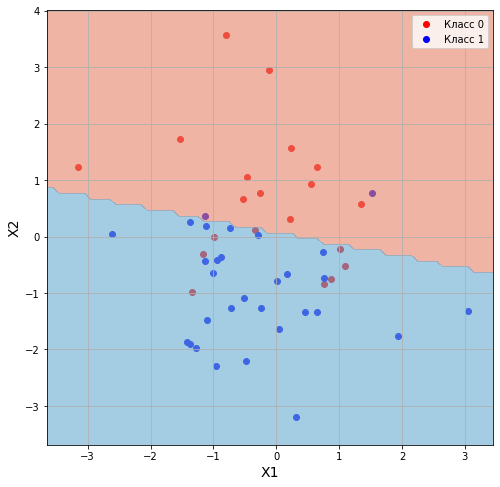

In [12]:
model = MyNet()

fitter = Fitter(model, n_epochs=500, batch_size=50, lr=0.001, weight_decay=0.1)
_ = fitter.fit(X_train, y_train, X_test, y_test)

# обучающая выборка
plot_decision_boundary(fitter)

## Dropout

Добавим в сеть `Dropout` слои

In [13]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        
        self.net = nn.Sequential(nn.Linear(2, 100), 
                                 nn.Tanh(), 
                                 nn.Dropout(0.5),
                                 nn.Linear(100, 100), 
                                 nn.Tanh(), 
                                 nn.Dropout(0.5),
                                 nn.Linear(100, 1), 
                                 nn.Sigmoid())
        

    def forward(self, x):
        return self.net(x)

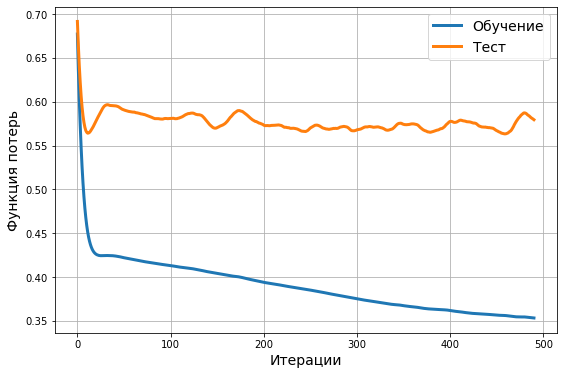

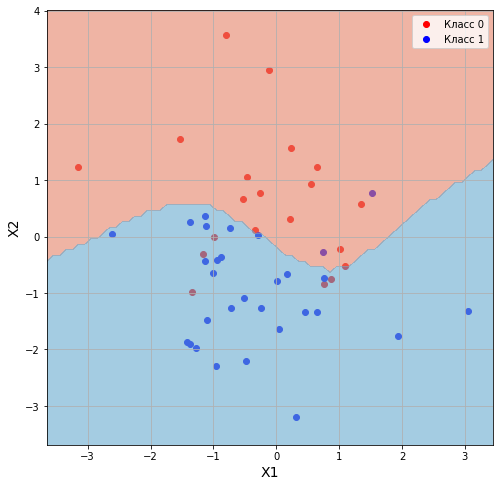

In [14]:
model = MyNet()

fitter = Fitter(model, n_epochs=500, batch_size=50, lr=0.001, weight_decay=0.)
_ = fitter.fit(X_train, y_train, X_test, y_test)

# обучающая выборка
plot_decision_boundary(fitter)

## Снижение сложности модели

In [15]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        
        self.net = nn.Sequential(nn.Linear(2, 10), 
                                 nn.Tanh(), 
                                 nn.Linear(10, 1), 
                                 nn.Sigmoid())
        

    def forward(self, x):
        return self.net(x)

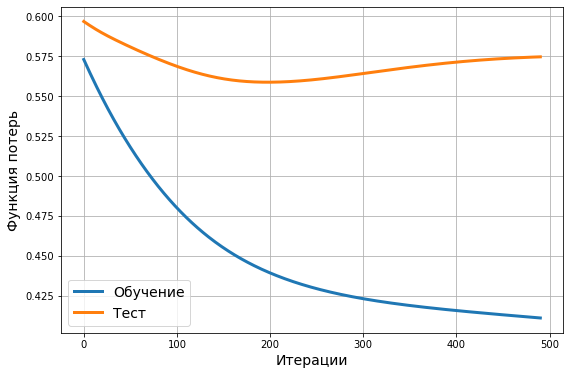

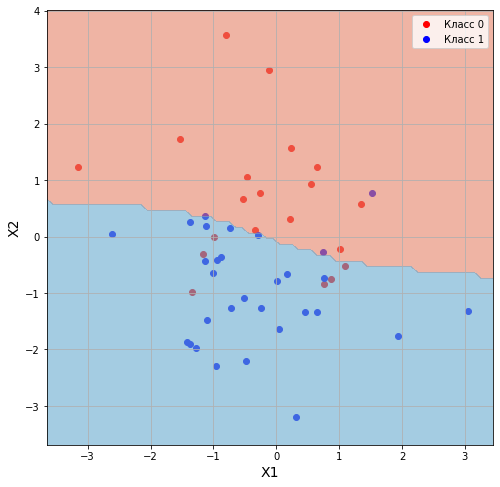

In [16]:
model = MyNet()

fitter = Fitter(model, n_epochs=500, batch_size=50, lr=0.001, weight_decay=0.)
_ = fitter.fit(X_train, y_train, X_test, y_test)

# обучающая выборка
plot_decision_boundary(fitter)